In [2]:
import json 
import numpy as np

quizResults = json.load(open("quizResults.txt"))
quizResults = [json.loads(q[0]) for q in quizResults[1:]]
quizResults = [q for q in quizResults if len(q['answers'])  == 20 and not 'unsure' in q['answers']]

In [3]:
def correct(res, ind):
    q = res['questions'][ind]
    ans = res['answers'][ind]
    return q['query'][7] == 'c' and ans == 'no' or q['query'][7] == 't' and ans == 'yes'
    

def qType(res, ind):
    variation = "same" if res['questions'][ind]['query'][7] == 't' else "diff"
    timbre = "same" if res['questions'][ind]['targets'][0][5] == res['questions'][ind]['targets'][1][5] else "diff"
    return {'timbre': timbre, 'variation': variation}
    


metaInfo = []
# metaInfo is a list of the "graded" questions - formatted as below
# {'correct': True, 'qType': {'timbre': 'diff', 'variation': 'same'}}
# the qType has 2 parts 'timbre' - if its a question where the target was played on different timbres
#                       'variation' - if the query melody was the same as the target or a variation
 
for res in quizResults:
    metaInfo += [{'correct': correct(res, i), 'qType': qType(res, i)} for i in range(len(res['answers']))]

In [4]:
correctQs = [m for m in metaInfo if m['correct']]
qSame_vSame_correct = [m for m in correctQs if m['qType']['timbre'] == 'same' and m['qType']['variation'] == 'same']
qDiff_vDiff_correct = [m for m in correctQs if m['qType']['timbre'] == 'diff' and m['qType']['variation'] == 'diff']
qDiff_vSame_correct = [m for m in correctQs if m['qType']['timbre'] == 'diff' and m['qType']['variation'] == 'same']
qSame_vDiff_correct = [m for m in correctQs if m['qType']['timbre'] == 'same' and m['qType']['variation'] == 'diff']

wrongQs = [m for m in metaInfo if not m['correct']]
qSame_vSame_wrong = [m for m in wrongQs if m['qType']['timbre'] == 'same' and m['qType']['variation'] == 'same']
qDiff_vDiff_wrong = [m for m in wrongQs if m['qType']['timbre'] == 'diff' and m['qType']['variation'] == 'diff']
qDiff_vSame_wrong = [m for m in wrongQs if m['qType']['timbre'] == 'diff' and m['qType']['variation'] == 'same']
qSame_vDiff_wrong = [m for m in wrongQs if m['qType']['timbre'] == 'same' and m['qType']['variation'] == 'diff']

In [5]:
print (len(qSame_vSame_correct), len(qDiff_vDiff_correct), len(qDiff_vSame_correct), len(qSame_vDiff_correct), len(correctQs))
print (len(qSame_vSame_wrong), len(qDiff_vDiff_wrong), len(qDiff_vSame_wrong), len(qSame_vDiff_wrong), len(wrongQs))


(54, 43, 47, 41, 185)
(36, 47, 43, 49, 175)


In [6]:
NUM_SUBJECTS = len(quizResults)
NUM_GROUPS = 2
DF = NUM_GROUPS * NUM_SUBJECTS - NUM_GROUPS
ALPHA = 0.05
NTAILS = 2
def same_timbre(res, ind):
    return res['questions'][ind]['targets'][0][5] == res['questions'][ind]['targets'][1][5]


In [7]:
qSame_accuracy_samples = []
qDiff_accuracy_samples = []  

for res in quizResults:
    qSame_correct = [i for i in range(len(res['answers'])) if correct(res, i) and same_timbre(res, i)]
    qDiff_correct = [i for i in range(len(res['answers'])) if correct(res, i) and not same_timbre(res, i)]
    qSame_accuracy_samples.append(len(qSame_correct) * 2.0 / len(res['answers']))
    qDiff_accuracy_samples.append(len(qDiff_correct) * 2.0 / len(res['answers']))

qSame_accuracy_samples = np.asarray(qSame_accuracy_samples)
qDiff_accuracy_samples = np.asarray(qDiff_accuracy_samples)

qSame_mean = qSame_accuracy_samples.mean()
qDiff_mean = qDiff_accuracy_samples.mean()

qSame_var = qSame_accuracy_samples.var(ddof=1)
qDiff_var = qDiff_accuracy_samples.var(ddof=1)

t = (qSame_mean - qDiff_mean) / np.sqrt(qSame_var / NUM_SUBJECTS + qDiff_var / NUM_SUBJECTS)


print(qSame_mean, qDiff_mean)
print(qSame_var, qDiff_var)
print(t)

(0.52777777777777768, 0.5)
(0.030359477124182997, 0.030588235294117642)
0.477369916871


In [30]:
print 0.030359477124182997**0.5, 0.030588235294117642**0.5

0.174239711674 0.174894926439


According to [this table](http://davidmlane.com/hyperstat/t_table.html), critical value for t (two-tailed, df=34, significance level=0.05) is 2.0322. Since t = 0.4774 < 2.0322, we accept the null hypothesis.

In [29]:
import scipy.stats as st

print st.ttest_rel(qSame_accuracy_samples, qDiff_accuracy_samples)
print st.ttest_ind(qSame_accuracy_samples, qDiff_accuracy_samples)

Ttest_relResult(statistic=0.43014409710600643, pvalue=0.67249408282133238)
Ttest_indResult(statistic=0.47736991687108909, pvalue=0.63615323033602555)


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Text(0.5,1,'T Distribution')

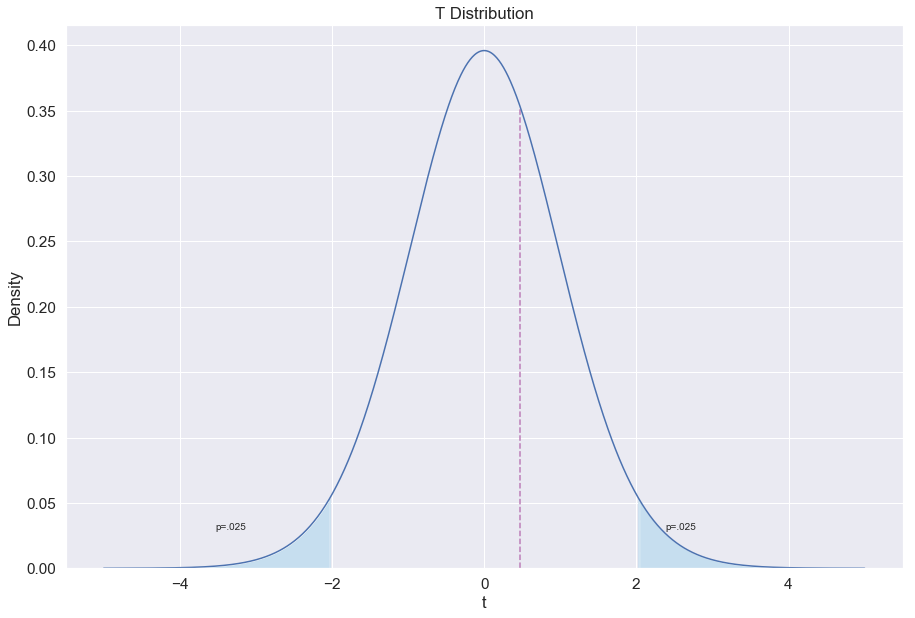

In [43]:
%matplotlib inline
import scipy.stats as st
import matplotlib.pyplot as plt
t_critical = abs(st.t.ppf(ALPHA/NTAILS, DF))
plt.figure(figsize=(15,10))
x = np.linspace(-5, 5, 1000)
y = st.t.pdf(x, DF)
plt.plot(x, y)
axes = plt.gca()
axes.set_ylim([0, None])
axes.fill_between(x, 0, y, where=x > t_critical, facecolor='#c6deef')
axes.fill_between(x, 0, y, where=x < -t_critical, facecolor='#c6deef')
axes.annotate('p=.025', xy=(t_critical+0.35, 0.03))
axes.annotate('p=.025', xy=(-t_critical-1.5, 0.03))
plt.vlines([-t_critical, t_critical], 0.0, st.t.pdf(t_critical, DF), colors='#c6deef')
plt.vlines(t, 0.0, st.t.pdf(t, DF), colors='#bc7eb8', linestyle='--')
plt.xlabel('t')
plt.ylabel('Density')
plt.title('T Distribution')

In [49]:
effect_size = np.sqrt(t**2 / (t**2 + DF))
print(effect_size)

0.08159527936007178


In [26]:
CONFIDENCE = 0.95
def mean_confidence_interval(data, confidence=0.95):
    m = data.mean()
    se = st.sem(data)
    n = len(data)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return h

Text(0.5,1,'Mean and Confidence Interval')

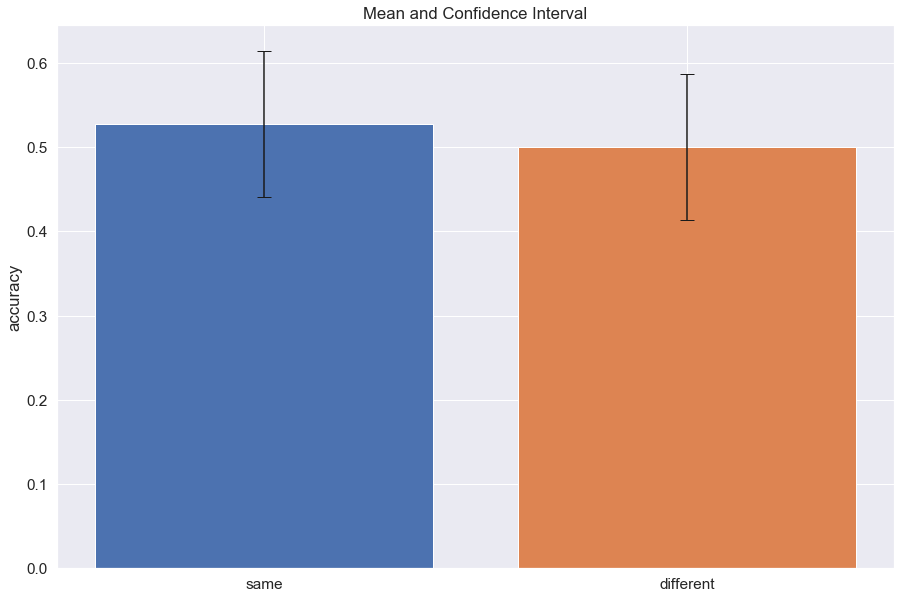

In [44]:
qSame_error = mean_confidence_interval(qSame_accuracy_samples, CONFIDENCE)
qDiff_error = mean_confidence_interval(qDiff_accuracy_samples, CONFIDENCE)
plt.figure(figsize=(15,10))
plt.bar(0, qSame_mean, width=0.8, yerr=qSame_error, capsize=7)
plt.bar(1, qDiff_mean, width=0.8, yerr=qDiff_error, capsize=7)
plt.xticks([0, 1], ['same', 'different'])
plt.ylabel('accuracy')
plt.title('Mean and Confidence Interval')

Below is just the result of that quiz. For the experiment, only Type II error could occur (since we accept the null hypothesis but the null hypothesis could actually be false)

[[101, 96], [79, 84]]


Text(0.5,1,'Confusion Matrix - [True/False][Positive/Negative]')

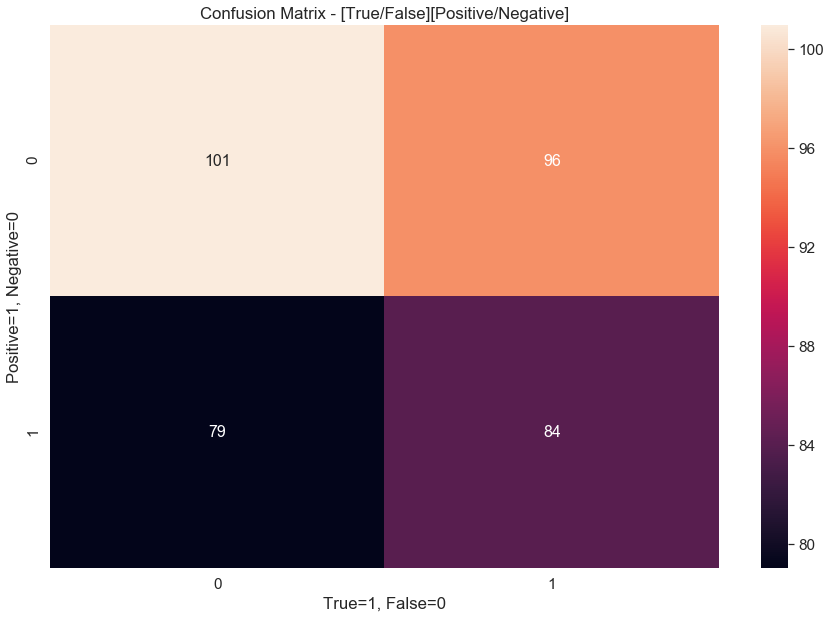

In [60]:
true_positive = len(qDiff_vDiff_correct) + len(qSame_vDiff_correct)
true_negative = len(qSame_vSame_correct) + len(qDiff_vSame_correct)
false_positive = len(qSame_vSame_wrong) + len(qDiff_vSame_wrong)
false_negative = len(qDiff_vDiff_wrong) + len(qSame_vDiff_wrong)

accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
inaccuracy = (false_positive + false_negative) / (true_positive + true_negative + false_positive + false_negative)
true_positive_rate = true_positive / (true_positive + false_negative)
true_negative_rate = true_negative / (true_negative + false_positive)
false_positive_rate = false_positive / (true_negative + false_positive)
false_negative_rate = false_negative / (true_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
prevalence = (true_positive + false_negative) / (true_positive + true_negative + false_positive + false_negative)

import seaborn as sn
confusion_matrix = [[true_negative, false_negative], [false_positive, true_positive]]
print confusion_matrix

plt.figure(figsize=(15,10))
axes = plt.axes()
sn.set(font_scale=1.4)
ht = sn.heatmap(confusion_matrix, annot=True,annot_kws={"size": 16}, fmt='g')
ht.set(xlabel='True=1, False=0', ylabel='Positive=1, Negative=0')
axes.set_title('Confusion Matrix - [True/False][Positive/Negative]')